In [ ]:
## LOADING ENV

In [2]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
from tqdm import tqdm
import random
import gym
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML
import math

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
''''
Function to load environment
'''
def LoadingEnv(seed = 0,name = 'Taxi-v3'):
  env = gym.make(name)
  env.reset(seed=seed)
  state_shape = env.observation_space.n
  no_of_actions = env.action_space.n
  return env,state_shape, no_of_actions

401
Number of states: 6
Number of actions that an agent can take: 500
Action taken: right
Transition probability: {'prob': 1.0, 'action_mask': array([1, 1, 0, 0, 0, 0], dtype=int8)}
Next state: 301
Reward recieved: -1
Terminal state: False


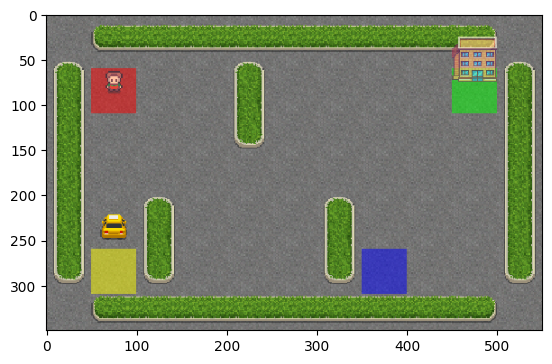

In [5]:

#Setting up the environment
env = gym.make('Taxi-v3')
env.reset()

#Current State
print(env.s)

# 4x12 grid = 48 states
print ("Number of states:", env.action_space.n)

# Primitive Actions
action = ["up", "right", "down", "left","pick","drop"]
#correspond to [0,1,2,3] that's actually passed to the environment

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.observation_space.n)

# Example Transitions
rnd_action = random.randint(0,5)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
plt.imshow(env.render('rgb_array'))

In [6]:
taxi_X, taxi_Y, Passanger, Destination  =  env.decode(env.s)
print(taxi_X, taxi_Y, Passanger, Destination )

3 0 0 1


In [7]:
env,state_size, no_of_actions = LoadingEnv(seed = 0)

In [8]:
## EP GREEDY POLICY FOR TD LEARNING:



seed = 0
rg = np.random.RandomState(seed)

def epsilon_policy(q_values, state, epsilon=0.1, rg=rg):
    i = rg.rand()
    if i < epsilon:
        action = rg.randint(q_values.shape[1])
    else:
        action = np.argmax(q_values[state])
    return action

In [9]:
## OPTIONS

In [10]:
goal_pos = env.unwrapped.locs
goal_pos

[(0, 0), (0, 4), (4, 0), (4, 3)]

In [11]:
'''
We have 4 goals and an option to go to each goal.
'''

num_options = 4

# Position of goals
goal_pos = env.unwrapped.locs

'''
Position of goals:
goal_pos = [(0, 0), (0, 4), (4, 0), (4, 3)]
red = (0,0)
green = (0,4)
yellow  = (4,0)
blue = (4,3)
'''

'''
For our option, the taxi goes to a specific goal location (R, G, Y, B).
After reaching there, it has the option of picking up or dropping the passenger.
If it's not at the goal location, it uses epsilon-greedy on option_qvalues to choose any primitive action.
'''

'''
Goal is R, G, Y, B
'''

def Deliver_policy(Q_option, goal_pos, goal, state, epsilon):
    # Decode the state into taxi position, passenger location, and drop location
    taxi_X, taxi_Y, Passenger, DropLoc = env.decode(state)

    # Initialize the option termination flag
    optdone = False

    # Check if the taxi is at the goal location
    if (taxi_X == goal_pos[goal][0] and taxi_Y == goal_pos[goal][1]):
        optdone =  True

        # If the passenger is at the goal location, pick them up
        if (Passenger == goal):
            optact = 4  # Pick up the passenger at the goal
        # If the drop location is at the goal location, drop the passenger
        elif (DropLoc == goal):
            optact = 5  # Drop the passenger at the goal
        else:  # If it's just a (R, G, Y, B) location but not a pickup or drop location
            # Choose the action based on epsilon-greedy policy
            optact = epsilon_policy(Q_option[goal], taxi_X * 5 + taxi_Y, epsilon)
    else:
        # If not at the goal location, choose the action based on epsilon-greedy policy
        optact = epsilon_policy(Q_option[goal], taxi_X * 5 + taxi_Y, epsilon)

    return [optact, optdone]


In [19]:
num_of_options = 4
N_options  = 4
N_goals = 4
N_passenger_location  = 5
N_row = 5
N_col  =5
Q_values_SMDP = np.ones((N_passenger_location*N_goals,N_options))
Q_values_options = np.ones((N_goals,5*5,no_of_actions-2))
alpha = 0.4
gamma = 0.99

In [18]:
def SMDP(seed, Deliver_policy=Deliver_policy):
    # Load the environment and set the state and action spaces
    env, state_space, action_space = LoadingEnv(seed=seed)

    # Initialize rewards and other variables
    rewards = []
    episodes = 1000
    eps = 0.1
    eps_options = {i: 0.1 for i in range(N_options)}  # Epsilon for each option
    count_success = 0

    # Loop through episodes
    for i in tqdm(range(episodes)):
        state = env.reset()
        done = False
        total_reward = 0

        # Loop until the episode is done
        while not done:
            # Decode the current state to get taxi location, passenger location, and drop location
            taxi_X, taxi_Y, Passenger, DropLoc = env.decode(state)

            # Determine the sub-state for transforming 500 states to fit in N_passenger_location * N_goals
            sub_state = Passenger * N_goals + DropLoc

            # Choose an option using epsilon-greedy policy
            option = epsilon_policy(Q_values_SMDP, sub_state, epsilon=eps)

            # Initialize variables for option execution
            reward_bar = 0
            opt_done = False
            steps = 0
            prev_state = state

            # Execute the option until it is done or the episode ends
            while not opt_done and not done:
                # Choose an action for the option
                Taxi_curr_X, Taxi_curr_Y, _, _ = env.decode(state)
                opt_act, opt_done = Deliver_policy(Q_values_options, goal_pos, option, state, eps_options[option])

                # Execute the action and observe the next state and reward
                next_state, reward, done, _ = env.step(opt_act)
                Taxi_next_X, Taxi_next_Y, _, _ = env.decode(next_state)
                # Update the surrogate reward based on whether the option is completed
                if opt_done:
                    reward_surr = reward  # Surrogate reward for completing the option
                else:
                    reward_surr = reward

                # Update Q-values if the action is primitive
                if opt_act < 4:
                    Q_values_options[option][5 * Taxi_curr_X + Taxi_curr_Y][opt_act] += alpha * (
                            reward + gamma * np.max(Q_values_options[option][5 * Taxi_next_X + Taxi_next_Y, :]) -
                            Q_values_options[option][5 * Taxi_curr_X + Taxi_curr_Y, opt_act])

                # Update variables
                steps += 1
                reward_bar = gamma * reward_bar + reward
                total_reward += reward
                state = next_state

            # Update SMDP Q-value
            _, _, passenger, DropLoc = env.decode(state)
            sub_state = N_goals * passenger + DropLoc

            _, _, passenger, DropLoc = env.decode(prev_state)
            prev_sub_state = N_goals * passenger + DropLoc

            Q_values_SMDP[prev_sub_state, option] += alpha * (
                        reward_bar + (gamma ** steps) * np.max(Q_values_SMDP[sub_state, :]) -
                        Q_values_SMDP[prev_sub_state, option])

        # Append total reward for the episode
        rewards.append(total_reward)

    return rewards


In [23]:
rewards = SMDP(0)

100%|██████████| 1000/1000 [00:02<00:00, 470.41it/s]


In [16]:
num_of_options = 4
N_options  = 4
N_goals = 4
N_passenger_location  = 5
N_row = 5
N_col  =5
Q_values_IOQL = np.ones((N_passenger_location*N_goals,N_options))
Q_values_options = np.ones((N_goals,5*5,no_of_actions-2))
alpha = 0.4
gamma = 0.99

In [17]:
def IOQL(seed,Deliver_policy = Deliver_policy):
    # Load the environment and set the state and action spaces
    env, state_space, action_space = LoadingEnv(seed=seed)

    # Initialize rewards and other variables
    rewards = []
    episodes = 1000
    eps = 0.1
    eps_options = {i: 0.1 for i in range(N_options)}  # Epsilon for each option
    count_success = 0

    # Loop through episodes
    for i in tqdm(range(episodes)):
        state = env.reset()
        done = False
        total_reward = 0

        # Loop until the episode is done
        while not done:
            # Decode the current state to get taxi location, passenger location, and drop location
            taxi_X, taxi_Y, Passenger, DropLoc = env.decode(state)

            # Calculate the sub-state to fit in N_passenger_location * N_goals by considering only passenger_loc, DropLoc
            sub_state = Passenger * N_goals + DropLoc

            # Choose an option using epsilon-greedy policy
            option = epsilon_policy(Q_values_IOQL, sub_state, epsilon=eps)

            # Initialize variables for option execution
            opt_done = False
            steps = 0
            prev_state = state

            # Execute the option until it is done or the episode ends
            while not opt_done and not done:
                # Decode the current state to get the taxi location, passenger location, and drop location
                Taxi_curr_X, Taxi_curr_Y, passenger, DropLoc = env.decode(state)

                # Calculate the sub-state
                sub_state = N_goals * passenger + DropLoc

                # Choose an action for the option
                opt_act, opt_done = Deliver_policy(Q_values_options, goal_pos, option, state, eps_options[option])

                # Execute the action and observe the next state and reward
                next_state, reward, done, _ = env.step(opt_act)

                # Decode the next state to get the taxi location, passenger location, and drop location
                Taxi_next_X, Taxi_next_Y, passenger1, DropLoc1 = env.decode(next_state)

                # Calculate the next sub-state
                next_sub_state = N_goals * passenger1 + DropLoc1

                # Update the surrogate reward based on whether the option is completed
                if opt_done:
                    reward_surr = 20  # Surrogate reward for completing the option
                else:
                    reward_surr = reward

                # Update Q-values if the action is primitive
                if opt_act < 4:
                    Q_values_options[option][5 * Taxi_curr_X + Taxi_curr_Y][opt_act] += alpha * (reward_surr + gamma * np.max(Q_values_options[option][5 * Taxi_next_X + Taxi_next_Y]) -Q_values_options[option][5 * Taxi_curr_X + Taxi_curr_Y, opt_act])

                # Update total reward
                total_reward += reward

                # Update Q-values for each option
                for O in range(N_options):
                    opt_act_option, opt_done_option = Deliver_policy(Q_values_options, goal_pos, O, state,eps_options[O])
                    if opt_act_option == opt_act:
                        if opt_done_option:
                            Q_values_IOQL[sub_state, O] += alpha * (reward + gamma * np.max(Q_values_IOQL[next_sub_state]) - Q_values_IOQL[sub_state, O])
                        else:
                            Q_values_IOQL[sub_state, O] += alpha * ( reward + gamma * (Q_values_IOQL[next_sub_state, O]) -Q_values_IOQL[sub_state, O])

                # Update the current state
                state = next_state

        # Append total reward for the episode
        rewards.append(total_reward)

    return rewards


In [26]:
rewards_IOQL = IOQL(0)

100%|██████████| 1000/1000 [00:02<00:00, 400.35it/s]


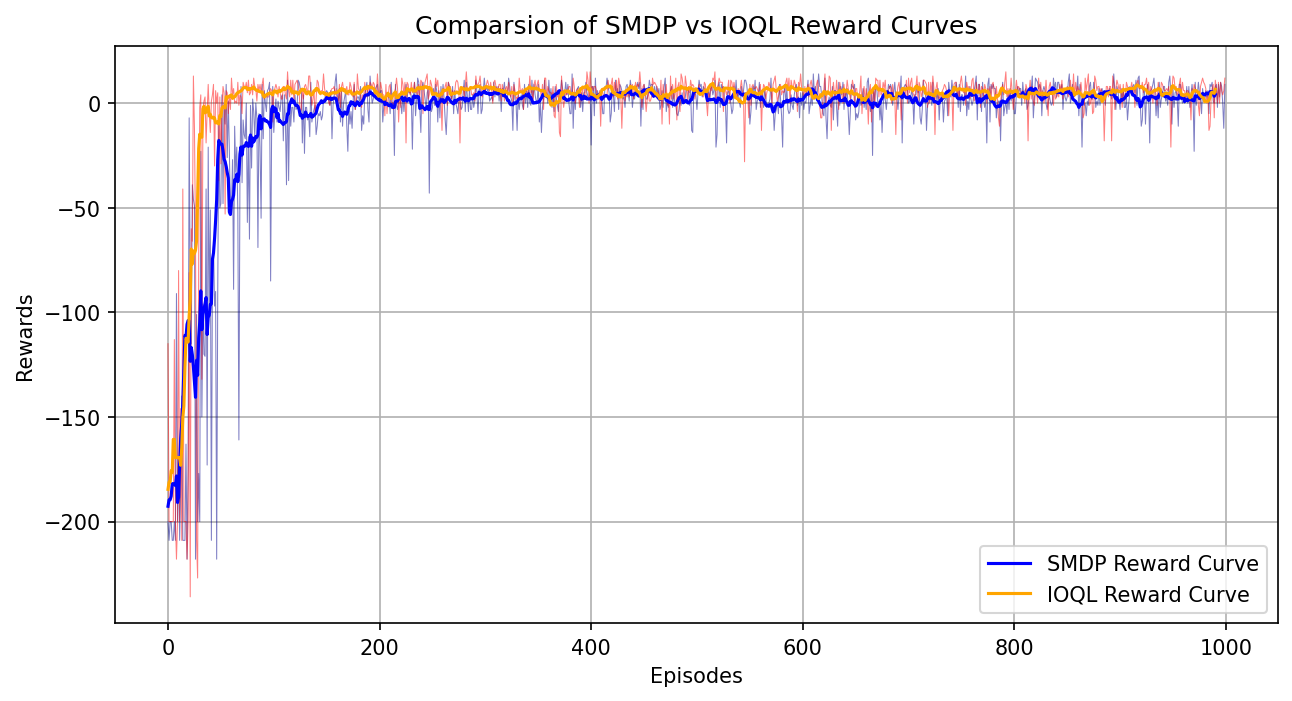

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Calculate the smoothed rewards using a moving average with window size 10
smoothed_rewards = moving_average(rewards, window_size=10)
smoothed_rewards_IOQL = moving_average(rewards_IOQL, window_size=10)


# Create a figure with higher DPI
plt.figure(figsize=(10, 5), dpi=150)

# # Plot the episodic reward curve with a thinner line
plt.plot(rewards, color='darkblue', linewidth=.5,alpha = 0.5)
plt.plot(rewards_IOQL, color='red', linewidth=.5,alpha = 0.5)


# Plot the smoothed reward curve
plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label='SMDP Reward Curve', color='blue', linewidth=1.5)
plt.plot(range(len(smoothed_rewards_IOQL)), smoothed_rewards_IOQL, label='IOQL Reward Curve', color='orange', linewidth=1.5)


# Add labels and title
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Comparsion of SMDP vs IOQL Reward Curves')

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
